In [5]:
import pandas as pd

# Load Xenium dataset
xenium_data_path = '../data/xenium/outs/transcripts.parquet'
xenium_df = pd.read_parquet(xenium_data_path)

xenium_df = xenium_df.sample(n=1000, random_state=42) 

In [7]:
from tifffile import imread

# Load the spatial image
image_path = '../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif'
img = imread(image_path)


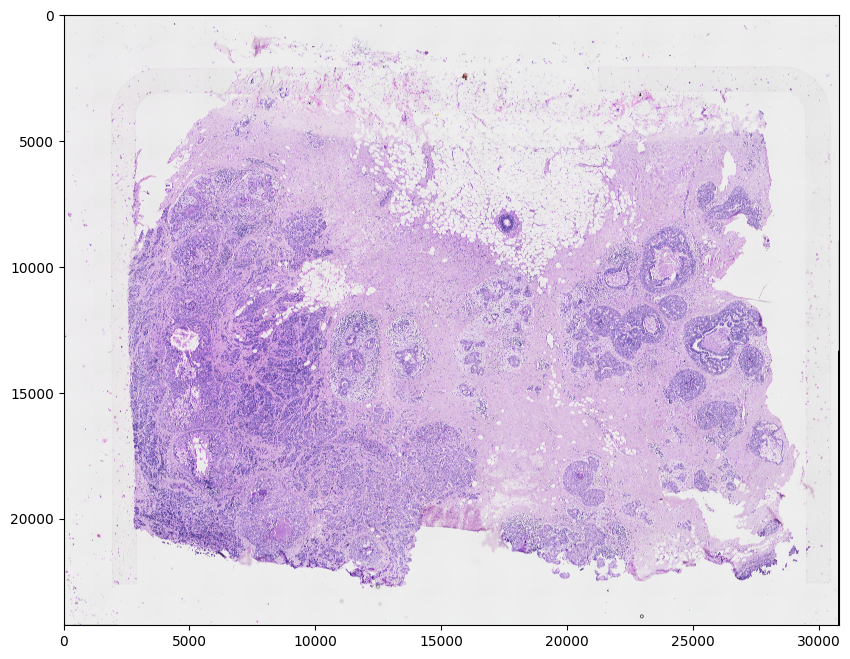

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform


# Plot the H&E image
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.show()


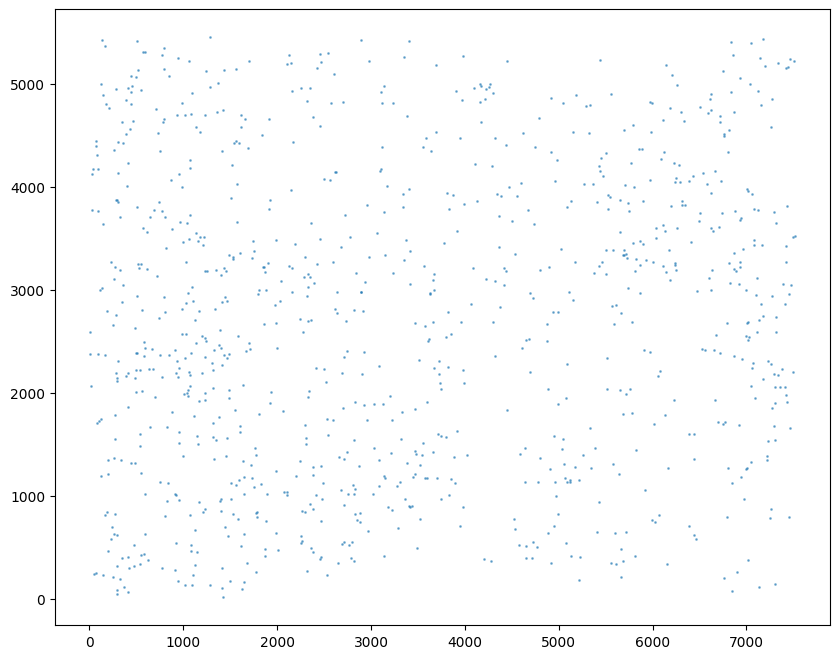

In [6]:
# Extract x and y centroid coordinates
x_coords = xenium_df['x_location']
y_coords = xenium_df['y_location']

# Plot the transcript coordinates
plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, s=1, alpha=0.5)
plt.show()


In [12]:
import numpy as np

# Define the transformation matrix from the CSV file
transform_matrix = np.array([
    [1.7125010585876286, 0.008345081015717404, -10397.19948741904],
    [0.008345081015717404, -1.7125010585876286, 37211.538978661185],
    [0, 0, 1]
])


In [13]:
# Prepare the coordinates in homogeneous form (add a third dimension of 1s)
coords = np.vstack([x_coords, y_coords, np.ones(len(x_coords))])


In [14]:
# Apply the transformation matrix to the coordinates
transformed_coords = transform_matrix @ coords

# Extract the transformed x and y coordinates
x_transformed = transformed_coords[0, :]
y_transformed = transformed_coords[1, :]


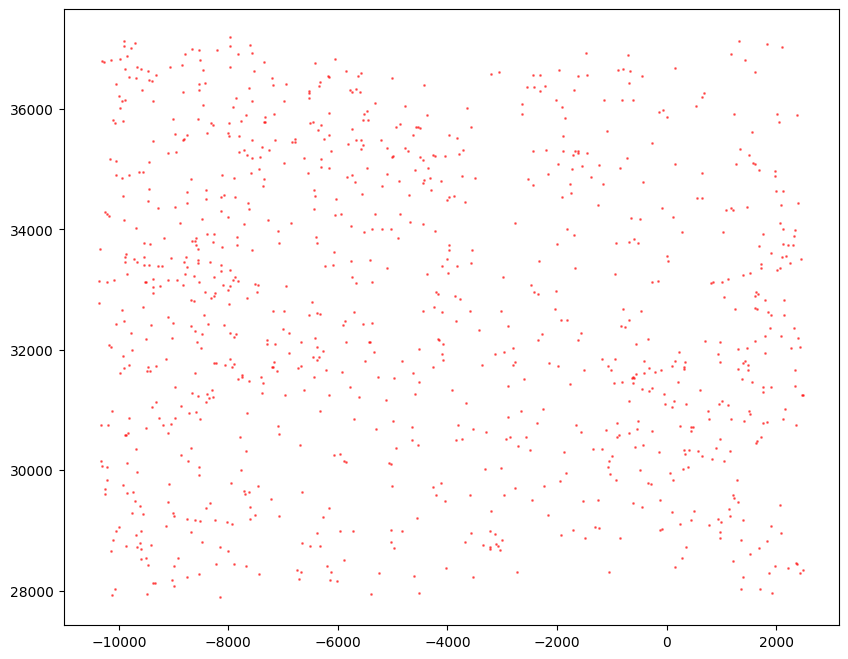

In [16]:
import matplotlib.pyplot as plt

# Plot the H&E image with the transformed coordinates overlaid
plt.figure(figsize=(10, 8))
#plt.imshow(img, extent=(0, img.shape[1], img.shape[0], 0))
plt.scatter(x_transformed, y_transformed, s=1, c='red', alpha=0.5)
plt.show()


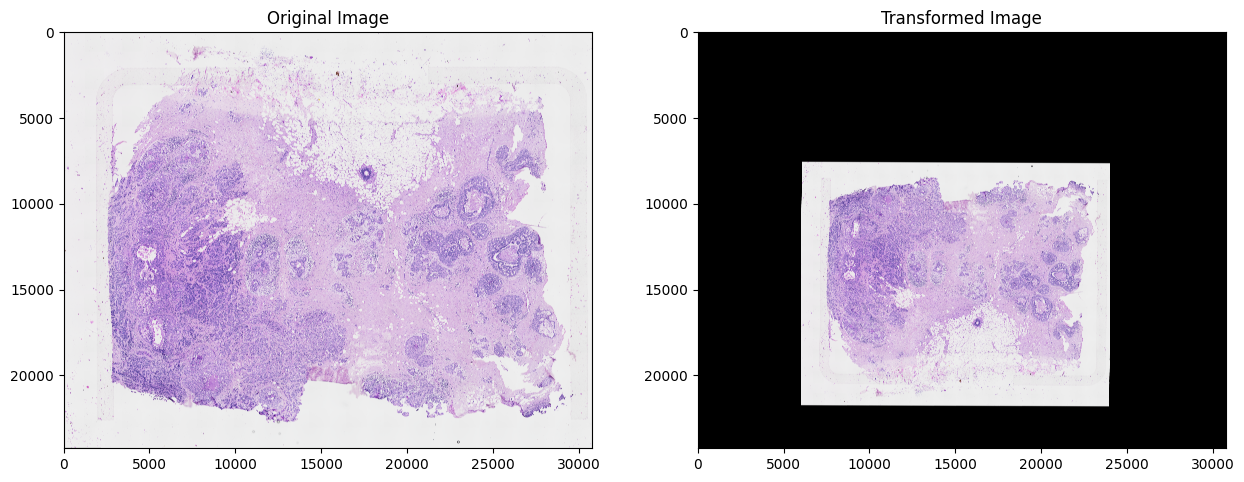

In [1]:
import numpy as np
from skimage import transform, io
import matplotlib.pyplot as plt
from tifffile import imread

# Load the image
image_path = '../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif'
img = imread(image_path)

# Transformation matrix (from the CSV)
affine_matrix = np.array([
    [1.7125010585876286, 0.008345081015717404, -10397.19948741904],
    [0.008345081015717404, -1.7125010585876286, 37211.538978661185],
    [0, 0, 1]
])

# Apply the affine transformation to the image using the full 3x3 matrix
transformed_img = transform.warp(img, inverse_map=transform.AffineTransform(matrix=affine_matrix))

# Plot the original and transformed images
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Transformed Image')
plt.imshow(transformed_img)
plt.show()


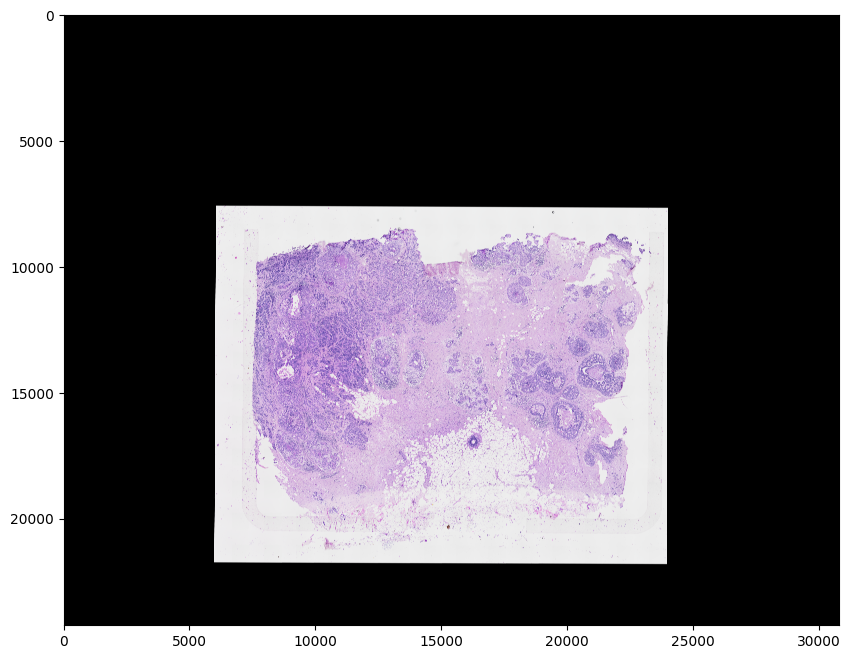

In [2]:
plt.figure(figsize=(10, 8))
plt.imshow(transformed_img)
plt.show()


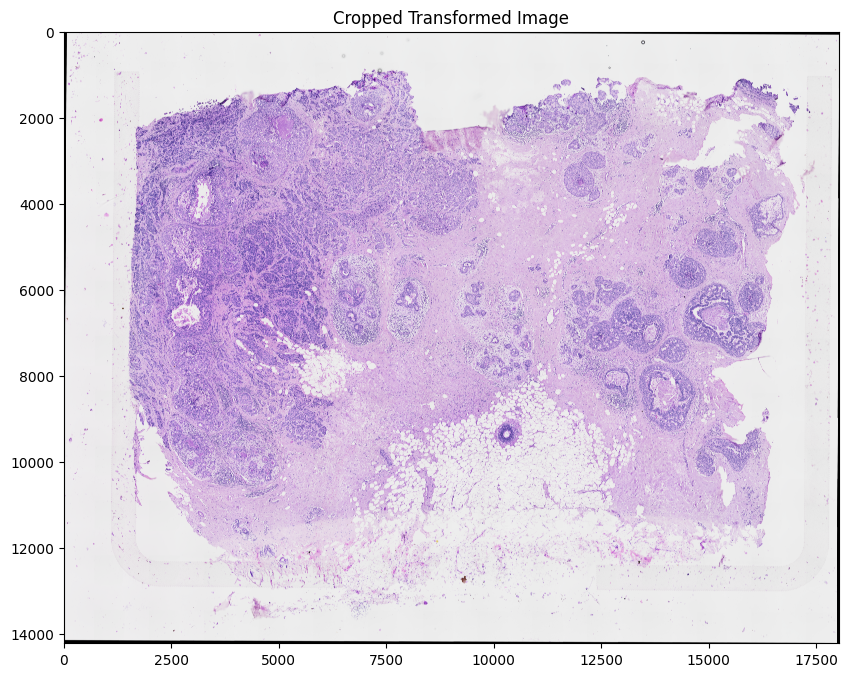

In [3]:
import numpy as np
from skimage import transform, io
import matplotlib.pyplot as plt
from tifffile import imread


# Determine the cropping box based on the actual content of the transformed image
non_black_pixels = np.where(transformed_img > 0)
min_row, max_row = non_black_pixels[0].min(), non_black_pixels[0].max()
min_col, max_col = non_black_pixels[1].min(), non_black_pixels[1].max()

# Crop the image
cropped_img = transformed_img[min_row:max_row+1, min_col:max_col+1]


plt.figure(figsize=(10, 8))
plt.title('Cropped Transformed Image')
plt.imshow(cropped_img)

plt.show()


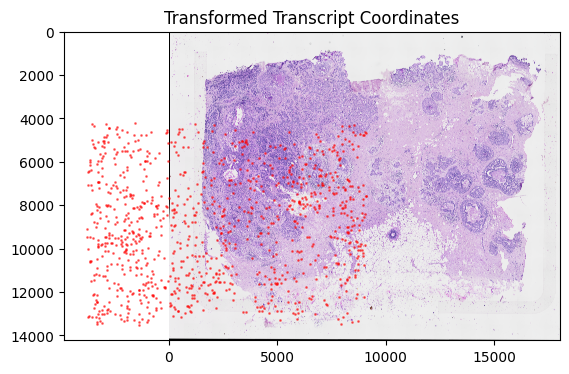

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example transcript coordinates (replace with your actual data)
transcript_coords = np.array([
    [x, y] for x, y in zip(xenium_df['x_location'], xenium_df['y_location'])
])

# Convert transcript coordinates from microns to pixels
micron_to_pixel = 0.363788  # Microns per pixel
transcript_coords_pixels = transcript_coords / micron_to_pixel

# Convert to homogeneous coordinates
ones = np.ones((transcript_coords_pixels.shape[0], 1))
homogeneous_coords = np.hstack([transcript_coords_pixels, ones])

# Transformation matrix (in pixels)
affine_matrix = np.array([
    [1.7125010585876286, 0.008345081015717404, -10397.19948741904],
    [0.008345081015717404, -1.7125010585876286, 37211.538978661185],
    [0, 0, 1]
])

# Apply the transformation
transformed_coords_pixels = homogeneous_coords @ affine_matrix.T

# Convert back to 2D coordinates
transformed_coords_pixels = transformed_coords_pixels[:, :2]

# Convert back to microns
transformed_coords_microns = transformed_coords_pixels * micron_to_pixel

# Assign back to your DataFrame
xenium_df['transformed_x'] = transformed_coords_microns[:, 0]
xenium_df['transformed_y'] = transformed_coords_microns[:, 1]

# Plot the transformed coordinates
plt.imshow(cropped_img, cmap='gray')
plt.scatter(xenium_df['transformed_x'], xenium_df['transformed_y'], s=1, alpha=0.5, c='red')
plt.title('Transformed Transcript Coordinates')
plt.show()
